# Thrust fault thermal evolution

The following is an example of the thermal decay of a near-surface granite intrusion, as presented in C Fowler's "The Solid Earth". 

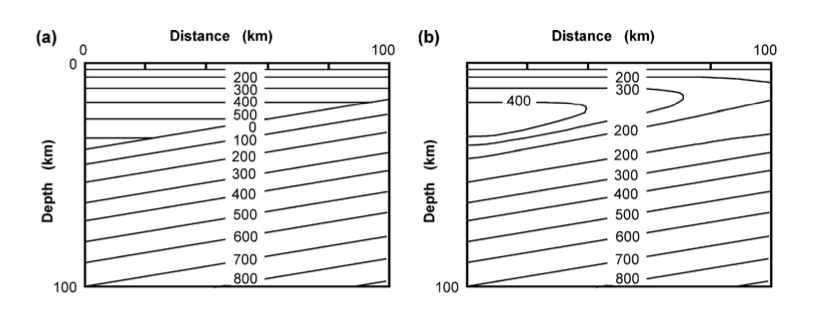

The Figure is originally from Fowler and Nisbet (1982). We take the configuration as inspiration for the folowing example.


In [1]:
import pylab as pl
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata



Next we import the planet_LB library, and create an object:

In [2]:
import planet_LB as p_LB

M2S = p_LB.Myr2s
Y2S = M2S/1e6
pLB = p_LB.planet_LB()

In [120]:
T_top=0.0 # Top temperature boundary condition

T_base=800.0

m=100
n=100
dx=1000
dy=1000
dist_x = dx*(n+1)
dist_y = dy*(m+1)
print(dist_x/1e3,"km")
H=0

#dt=25.0 *Y2S # Timesteps of 25 years (in sec)
dt = 1*M2S/mstep

    
kappa=1e-6 # Thermal diffusivity
mstep=1000 #40000
dt = 1*M2S/mstep
print(dt/Y2S,"yr")

101.0 km
1000.0 yr


In [121]:
lb_s = pLB.LB_D2Q9_init_ThermStruct(dt,m,n,dx,dy,T_base,H,kappa,mstep)
print(lb_s['mstep'])

1000


[[600. 590. 580. ...  30.  15.   0.]
 [602. 592. 582. ...  30.  15.   0.]
 [604. 594. 584. ...  30.  15.   0.]
 ...
 [796. 786. 776. ...  30.  15.   0.]
 [798. 788. 778. ...  30.  15.   0.]
 [800. 790. 780. ...  30.  15.   0.]]


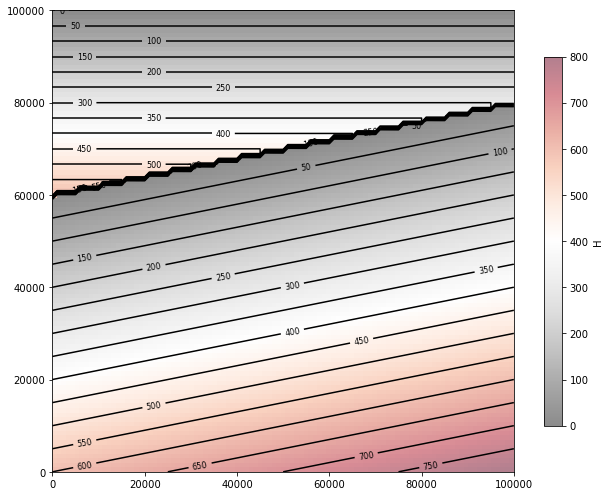

In [200]:
T = np.ones_like(lb_s['T'])
X = lb_s['x']
Y = lb_s['y']

#Impose initial linear gradient on Temp field
T1 = np.linspace(1500,0,m+1)
for j in np.arange(0,m+1,1):
    T[:,j] = T[:,j]*T1[j]
    
# Creating thrust initial thermal profile
# This fancy bit of linear algebra creates the condition.
p1 = np.array([0.0,60000.])
p2 = np.array([100000,80000])
p3=np.array([100000.,0.])
maxd=np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1)


for j in np.arange(0,m+1,1):
    for i in np.arange(0,n+1,1):
        p3 = np.array([X[i,j],Y[i,j]])
        d = np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1)
        if d< 0.0:
            T[i,j] = (d/maxd) * 800.

T_init = T
lb_s['T'] = T
lb_s['H'] = H
lb_s['T_top'] = T_top
lb_s['T_base'] = T_base

# View the initial condition
plt.figure(figsize=(9,7))
con1 = plt.contour(X,Y,T,15,colors='black')
plt.clabel(con1,inline=True,fontsize=8)
plt.imshow(lb_s['T'].T, extent=[0, n*dx, 0, m*dx], origin='lower', cmap='RdGy_r', alpha=0.5)

cbar=plt.colorbar(label='H',shrink=0.8);
plt.tight_layout()

print(lb_s['T'])

# About timesteps

There are a few stablility conditions to consider. 

Mohammad states that

Note that the value of dt should be less than or equal to 1⁄[(2alpha)/(dx^2) + u/dx]  to satisfy stability criterion.<br>
So stability requires:<br>
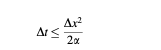
<br>

In [194]:
print("Our properties\n")
print("dt",lb_s['dt'],"dx",lb_s['dx'],"omega",lb_s['omega'],"tau",1/lb_s['omega'],"mstep",lb_s['mstep'])

lb_s['dt'] = 2000*Y2S
lb_s = pLB.update_time(age,lb_s)

# Print condition 2
print("\nStability Condition \n")
dx = lb_s['dx']
for t in [200,2000,20000,200000]:
    lb_s['dt'] = t*Y2S
    lb_s = pLB.update_time(age,lb_s)
    cond2 = dx**2/(2*lb_s['kappa'])
    if (lb_s['dt']/cond2 < 1):
        good = "good"
    else:
        good = "bad"
                   
    print("dt:",lb_s['dt'],"dt/cond:",lb_s['dt']/cond2,"   < 1?:", good) 
                   
print(" \n... good...\n")

print(cond2/Y2S," yrs = cutoff timestep")

Our properties

dt 6311520000000.0 dx 1000 omega 0.05145472807205309 tau 19.434559999999998 mstep 10

Stability Condition 

dt: 6311520000.0 dt/cond: 0.01262304    < 1?: good
dt: 63115200000.0 dt/cond: 0.1262304    < 1?: good
dt: 631152000000.0 dt/cond: 1.262304    < 1?: bad
dt: 6311520000000.0 dt/cond: 12.62304    < 1?: bad
 
... good...

15844.043907014475  yrs = cutoff timestep



So our stability conditions imply that timesteps less than ~ 15,000 will be stable. The solutions will get crap for larger timesteps (and you'll see the effects. Go on. Try it out). <br>
 ### Note:<br>
 
 Make sure you run the pLB.update_time(age,lb_s) routine if you change the timestep/mstep/age. If you get solutions that look different to what you are expecting, 90% of the time it will be one of these not being correct. The other 10% you are probably starting with the wrong thermal field, so make sure to re-initialise each run.


In [216]:
#Let's test an example at 2 Myr.

age=2 #Myr


lb_s['dt']= 200* Y2S #From previous analysis. Equivalent to age * M2S/lb_s['mstep']
lb_s['mstep'] = age*M2S/lb_s['dt']
lb_s = pLB.update_time(age,lb_s)
print("mstep:",lb_s['mstep'],"dt:",lb_s['dt']/Y2S, "Yr")

T=lb_s['T']
f=lb_s['f']

mstep = int(age*M2S/lb_s['dt'])

print(mstep,lb_s['dt']/Y2S,mstep*dt/Y2S)
    


mstep: 10000 dt: 200.0 Yr
10000 200.0 10000000.0


In [217]:
# Reinitialise the thermal field
T = T_init
timesteps = lb_s['dt']*np.arange(1,mstep+1,1)
for t in timesteps:
    lb_s['T']=T
    lb_s['f']=f
    lb_s =  pLB.LB_D2Q9_T(lb_s)
    T=lb_s['T']
    f=lb_s['f']
    
print(T)
    

[[800.         772.7790256  745.71978203 ...  32.64510519  16.31963467
    0.        ]
 [800.         772.7790256  745.71978203 ...  32.64510519  16.31963467
    0.        ]
 [800.         772.78756862 745.73565035 ...  32.64570017  16.31995614
    0.        ]
 ...
 [800.         788.10615369 776.2271419  ...  27.29115799  13.70882254
    0.        ]
 [800.         788.11472315 776.24305708 ...  27.28152784  13.70367863
    0.        ]
 [800.         788.11472315 776.24305708 ...  27.28152784  13.70367863
    0.        ]]


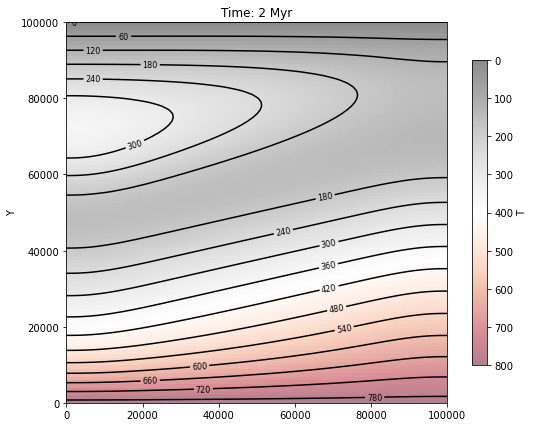

In [218]:
plt.figure(figsize=(9,7))
plt.tight_layout()

#plt.subplot(2,2,1)
con1 = plt.contour(X,Y,T,15,colors='black')
plt.clabel(con1,inline=True,fontsize=8)
plt.ylabel("Y")
plt.title("Time: {} Myr".format(age))
plt.imshow(lb_s['T'].T, extent=[0, n*dx, 0, m*dx], origin='lower', cmap='RdGy_r', alpha=0.5)
#plt.colorbar();
cbar=plt.colorbar(label='T',shrink=0.8);
cbar.ax.invert_yaxis() 

# Create a series

In [219]:
# Define a plotting routine

def plot_results(lb_s,i,ages):
    plt.subplot(2,2,i+1)
    X = lb_s['x']
    Y = lb_s['y']
    T = lb_s['T']
    n = lb_s['n']
    m = lb_s['m']
    dx = lb_s['dx']
    dy = lb_s['dy']
    con1 = plt.contour(X,Y,T,15,colors='black')
    plt.clabel(con1,inline=True,fontsize=8)
    plt.ylabel("Y")
    plt.title("Time: {} Myr".format(ages[i]))
    plt.imshow(T.T, extent=[0, n*dx, 0, m*dx], origin='lower', cmap='RdGy_r', alpha=0.5)
    cbar=plt.colorbar(label='T',shrink=0.8);
    cbar.ax.invert_yaxis()

1.0
2.0
5.0


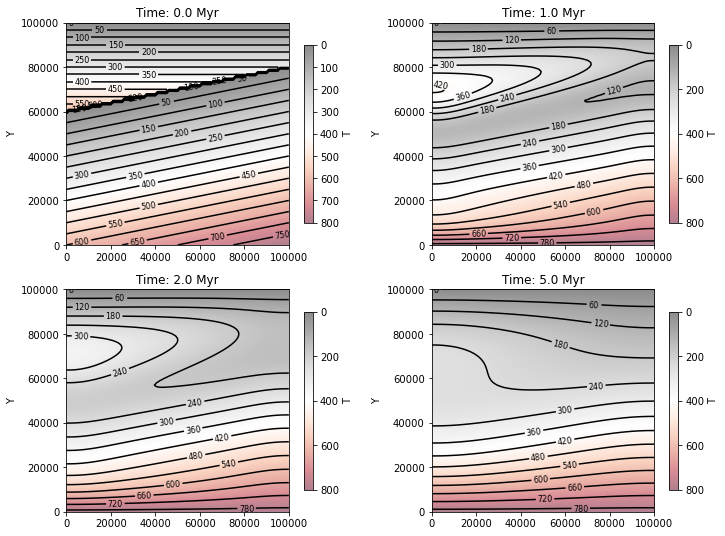

In [220]:
#Reinitialise T field
lb_s['T'] = T_init
T  = T_init

ages = [0.0, 1.0, 2.0, 5.0]
lb_s['dt'] = 200*Y2S
lb_s = pLB.update_time(age,lb_s)
mstep = int(ages[3]*M2S/lb_s['dt'])
lb_s['mstep'] =  mstep

# Configure the plot
plt.figure(figsize=(12,9))
plt.tight_layout()

i=0
plot_results(lb_s,i,ages)
i += 1
timesteps = lb_s['dt']*np.arange(1,mstep+1,1)
for t in timesteps:
    lb_s['T']=T
    lb_s['f']=f
    lb_s =  pLB.LB_D2Q9_T(lb_s)
    T=lb_s['T']
    f=lb_s['f']
    #print(i,t/M2S)
    if t/M2S >= ages[i]:
        print(ages[i])
        plot_results(lb_s,i,ages)
        i +=1

plt.savefig("Fowler_thrust.png")